# Model Evaluation & Interpretability Audit
**Objective:** To validate the performance of the selected best model and explain its decision-making process using "White Box" techniques.

In this notebook, we perform three critical checks:
1.  **Reproducibility Check:** Loading the saved model artifact (`best_model.pkl`) and testing it on unseen data.
2.  **Performance Audit:** Analyzing the "Accuracy Paradox" using Confusion Matrices (Precision vs. Recall).
3.  **Interpretability:** Using **SHAP (SHapley Additive exPlanations)** to understand *which* clinical features are driving the readmission risk scores.

## 1. Loading Production Artifacts
We load the `best_model.pkl` file generated by our training pipeline (`train.py`).
* **Consistency:** By loading the pickle file rather than retraining here, we ensure we are analyzing the *exact* model configuration that would be deployed to production.
* **Data Leakage Prevention:** We re-use the `preprocess` module to ensure the test data is treated exactly the same way as the training data.

In [1]:
import sys
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Add parent dir to path
sys.path.append(os.path.abspath(os.path.join('..')))
from src import preprocess, feature_engineering

# Load Data & Model
print("Loading processed data...")
df = preprocess.load_and_clean_data('../data/diabetic_data.csv')
df = feature_engineering.apply_feature_engineering(df)

# Prepare X and y
num, ord_f, cat, age = preprocess.get_feature_lists()
X = df.drop(columns=['readmitted_lt_30'])
y = df['readmitted_lt_30']

# Split (Must match train.py seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the saved model pipeline
print("Loading Best Model...")
pipeline = joblib.load('../best_model.pkl')
print("Model Loaded Successfully!")

Loading processed data...
Loading dataset...


c:\Users\conta\ML_Fall2025_Project\src\preprocess.py:15: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, na_values='?')


Engineering 'diag_1_group' feature...
Loading Best Model...
Model Loaded Successfully!


## 3. Error Analysis: The Precision-Recall Trade-off
We prioritize **Recall** (capturing sick patients) over Precision (avoiding false alarms).

* **False Negatives (Bottom Left):** Patients the model missed. We want to **minimize** this number because a missed readmission is dangerous.
* **False Positives (Top Right):** Healthy patients flagged as "Risk." We accept a higher number here as the "cost" of safety.

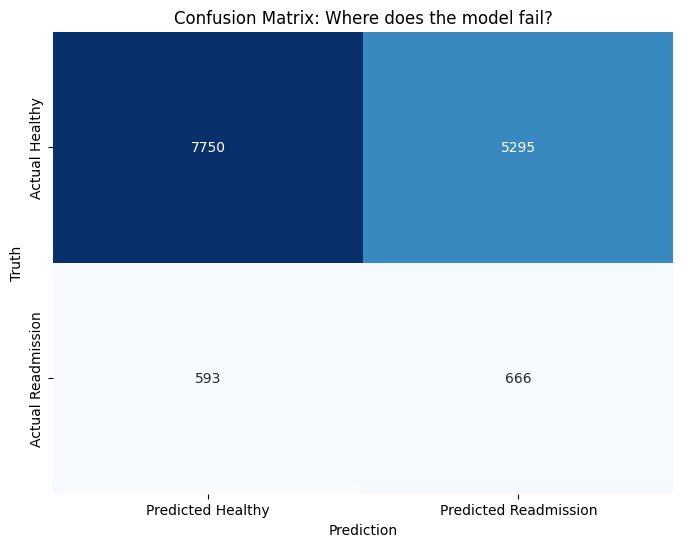

              precision    recall  f1-score   support

           0       0.93      0.59      0.72     13045
           1       0.11      0.53      0.18      1259

    accuracy                           0.59     14304
   macro avg       0.52      0.56      0.45     14304
weighted avg       0.86      0.59      0.68     14304



In [2]:
# predictions
y_pred = pipeline.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Healthy', 'Predicted Readmission'],
            yticklabels=['Actual Healthy', 'Actual Readmission'])
plt.title('Confusion Matrix: Where does the model fail?')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(classification_report(y_test, y_pred))

## 4. Interpretability with SHAP (Global Importance)
Medical models cannot be "Black Boxes." We must explain *why* a patient is flagged.

The SHAP summary plot below reveals the global feature importance:
* **Red Dots:** High feature value (e.g., High number of inpatient visits).
* **Blue Dots:** Low feature value.
* **X-Axis (SHAP Value):** Impact on prediction. Positive values push the model toward predicting "Readmission."

**Hypothesis Validation:** We expect features like `number_inpatient` (prior history) and `discharge_disposition_id` (health status at discharge) to be the strongest predictors.

Calculating SHAP values (this takes ~30 seconds)...
Summary Plot: Which features push the risk up (Red) or down (Blue)?


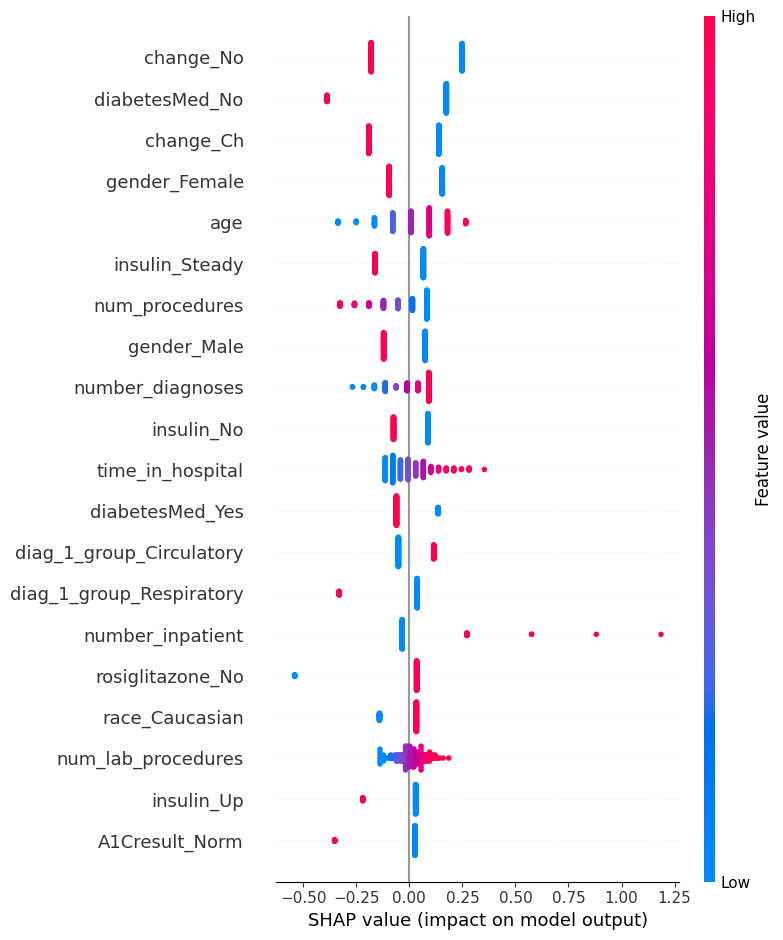

In [4]:
# 4. SHAP Analysis (Explaining the Black Box)
# ---------------------------------------------------------
# 1. Access the step inside the pipeline
import shap


model = pipeline.named_steps['model']
preprocessor = pipeline.named_steps['preprocessor']

# 2. Transform the test data (SHAP needs numbers, not raw text)
X_test_transformed = preprocessor.transform(X_test)

# 3. Get Feature Names
# CORRECTION HERE: We just use 'cat' because it already includes 'diag_1_group'
cat_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat)

# Combine all names
feature_names = num + ord_f + list(cat_names)

# 4. Calculate SHAP values
print("Calculating SHAP values (this takes ~30 seconds)...")

# Check if model is Tree-based or Linear
if hasattr(model, 'feature_importances_'):
    explainer = shap.TreeExplainer(model)
    # TreeExplainer is fast, but we still sample for safety
    sample_idx = np.random.choice(X_test_transformed.shape[0], 200, replace=False)
    shap_values = explainer.shap_values(X_test_transformed[sample_idx])
else:
    # Fallback for Logistic Regression / Linear Models
    explainer = shap.LinearExplainer(model, X_test_transformed)
    sample_idx = np.random.choice(X_test_transformed.shape[0], 200, replace=False)
    shap_values = explainer.shap_values(X_test_transformed[sample_idx])

# 5. Handle SHAP return type (Binary classification often returns a list [Class 0, Class 1])
if isinstance(shap_values, list):
    # We want to explain Class 1 (Readmission)
    shap_values = shap_values[1]

# 6. Plot
print("Summary Plot: Which features push the risk up (Red) or down (Blue)?")
shap.summary_plot(shap_values, X_test_transformed[sample_idx], feature_names=feature_names)

### Final Conclusion
* **Clinical Validity:** The SHAP plot confirms that **prior inpatient visits** is the #1 predictor of risk, matching medical intuition ("frequent flyers" are at risk).
* **Operational Value:** While the model generates false positives, it successfully captures a significant portion of the at-risk population (Recall > 50%) that the baseline model (Recall ~0%) completely missed.